In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import f_oneway
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.manifold import TSNE

Quantity_per_Chrono = pd.read_excel('python_2_All_Pottery_Totals_per_Chrono_Qty.xlsx')
Weight_per_Chrono = pd.read_excel('python_3_All_Pottery_Totals_per_Chrono_Wt.xlsx')
Fine_quantity = pd.read_excel('2a_Fine_Pottery_Totals_per_Chrono_Qty.xlsx')
Medium_quantity = pd.read_excel('2b_MedCoarse_Pottery_Totals_per_Chrono_Qty.xlsx')
Coarse_quantity = pd.read_excel('2c_Coarse_Pottery_Totals_per_Chrono_Qty.xlsx')
Fine_weight = pd.read_excel('3a_Fine_Pottery_Totals_per_Chrono_Wt.xlsx')
Medium_weight = pd.read_excel('3b_MedCoarse_Pottery_Totals_per_Chrono_Wt.xlsx')
Coarse_weight = pd.read_excel('3c_Coarse_Pottery_Totals_per_Chrono_Wt.xlsx')

time_period_columns = ['05_Neo', '25_EBA', '35_MBA', '45_LBA', '55_PG']



def classify_region(grsu):
    x = grsu[:2]
    y = int(grsu[2:5])
    if x >= 'LD' and x <= 'LG' and y >= 789 and y <= 795:
        return 'Grave'
    elif x >= 'LL' and x <= 'LQ' and y >= 782 and y <= 787:
        return 'Settlement'



for df in [Quantity_per_Chrono, Weight_per_Chrono, Fine_quantity, Fine_weight, Medium_quantity, Medium_weight, Coarse_quantity, Coarse_weight]:
    df['Region'] = df['GRSU'].apply(classify_region)


#quantity
grave_df_q = Quantity_per_Chrono[Quantity_per_Chrono['Region'] == 'Grave'].copy()
settlement_df_q = Quantity_per_Chrono[Quantity_per_Chrono['Region'] == 'Settlement'].copy()

#weight
grave_df_w = Quantity_per_Chrono[Quantity_per_Chrono['Region'] == 'Grave'].copy()
settlement_df_w = Quantity_per_Chrono[Quantity_per_Chrono['Region'] == 'Settlement'].copy()


#extract relevant time period columns
Quantity_per_Chrono_grave = grave_df_q[time_period_columns]
Quantity_per_Chrono_settlement = settlement_df_q[time_period_columns]
Weight_per_Chrono_grave = grave_df_w[time_period_columns]
Weight_per_Chrono_settlement = settlement_df_w[time_period_columns]


#normalize data
scaler = StandardScaler()
data_scaled_q_grave = scaler.fit_transform(Quantity_per_Chrono_grave)
data_scaled_q_settlement = scaler.fit_transform(Quantity_per_Chrono_settlement)
data_scaled_w_grave = scaler.fit_transform(Weight_per_Chrono_grave)
data_scaled_w_settlement = scaler.fit_transform(Weight_per_Chrono_settlement)


#combine data
combined_data_gsq = pd.concat([Quantity_per_Chrono_grave, Quantity_per_Chrono_settlement])
combined_data_gsw = pd.concat([Weight_per_Chrono_grave, Weight_per_Chrono_settlement])


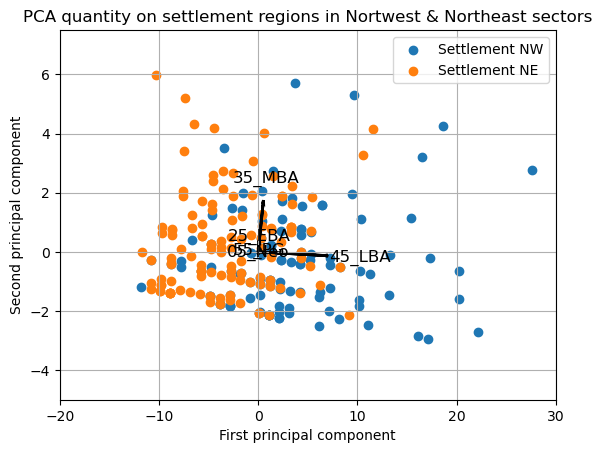

In [11]:
#PCA
pca_combined = PCA(n_components=2)
principal_components_combined = pca_combined.fit_transform(combined_data_gsq)

#transform seperate regions using combined PCA model
principal_components_q_grave = pca_combined.transform(Quantity_per_Chrono_grave)
principal_components_q_settlement = pca_combined.transform(Quantity_per_Chrono_settlement)

#principal dataframes
principal_df_q_grave = pd.DataFrame(data=principal_components_q_grave, columns=['PC1', 'PC2'])
principal_df_q_settlement = pd.DataFrame(data=principal_components_q_settlement, columns=['PC1', 'PC2'])

#function for base vectors
def plot_pca_arrows(pca, columns, ax):
    feature_vectors = pca.components_.T * np.sqrt(pca.explained_variance_)
    for i, v in enumerate(columns):
        ax.arrow(0, 0, feature_vectors[i, 0], feature_vectors[i, 1], head_width=0.1, head_length=0.1, linewidth=2, fc='black', ec='black')
        ax.text(feature_vectors[i, 0] * 1.5, feature_vectors[i, 1] * 1.5, v, color='black', ha='center', va='center', fontsize=12)

fig, ax = plt.subplots()
ax.scatter(principal_df_q_grave['PC1'], principal_df_q_grave['PC2'], label='Settlement NW')
ax.scatter(principal_df_q_settlement['PC1'], principal_df_q_settlement['PC2'], label='Settlement NE')

#, alpha=0.5 for 
ax.set_title('PCA quantity on settlement regions in Nortwest & Northeast sectors')
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
ax.grid(True)
ax.legend()
plot_pca_arrows(pca_combined, time_period_columns, ax)

ax.set_xlim(-20, 30)  
ax.set_ylim(-5, 7.5)  
plt.show()


In [12]:


explained_variance_ratio = pca_combined.explained_variance_ratio_
print("Explained variance ratio:", explained_variance_ratio)



Explained variance ratio: [0.90934727 0.05495438]


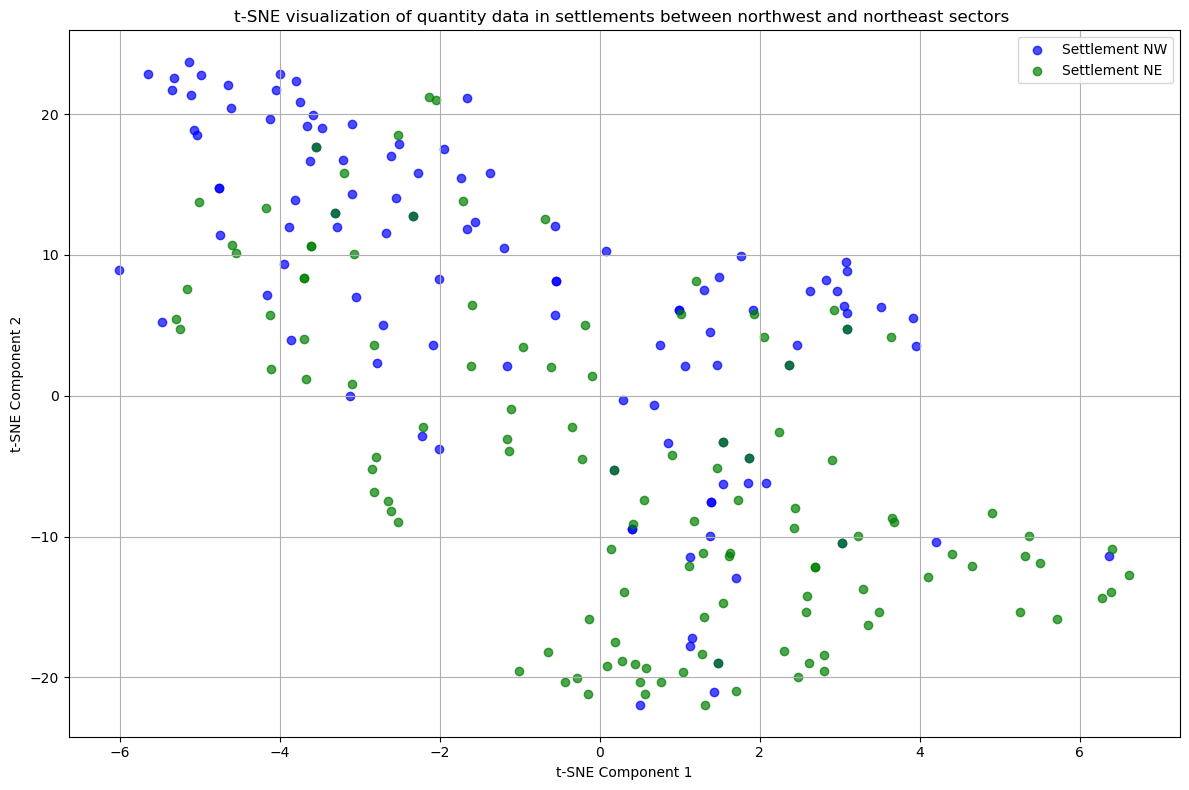

In [16]:
tsne = TSNE(n_components=2, random_state=42)
data_tsne_q = tsne.fit_transform(combined_data_gsq)


combined_regions = pd.concat([
    pd.Series(['Settlement NW'] * Quantity_per_Chrono_grave.shape[0]),
    pd.Series(['Settlement NE'] * Quantity_per_Chrono_settlement.shape[0])
])

plt.figure(figsize=(12, 8))
colors = {'Settlement NW': 'blue', 'Settlement NE': 'green'}

for region in colors.keys():
    mask = (combined_regions == region)
    plt.scatter(data_tsne_q[mask, 0], data_tsne_q[mask, 1], color=colors[region], label=region, alpha=0.7)

plt.title('t-SNE visualization of quantity data in settlements between northwest and northeast sectors ')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()